# figure 4, feedforward and feedback combined 

In [1]:
import numpy as np
from scipy.integrate import odeint  
from operator import sub 
import controlpy   
import pickle

from matplotlib import  rc    
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import rcParams 

import sys 
import  os 

# append function path to system
base_path = os.path.dirname( os.getcwd()  )  
function_path = os.path.join(  base_path, 'functions') 
sys.path.append(function_path ) 
 
figs_path = os.path.join(  base_path, 'figs') 
data_path = os.path.join(  base_path, 'data')
    
# import custom functions 
from figure_settings import *    
import figure_functions as ff
import phasediagram as phd
import singlependulum as sp  
import dynamicpendulums.figureparam as fp

In [2]:
# General Plotting Parameters 
fig_dim = (6.2,2 ) 
fig_name = 'fig4_feedforward_feedback' 

LQR_limit = 0.3

In [3]:

A = np.matrix([[0.,1.],[-10.,0. ]])
B = np.matrix([[0.],[1.]])
Q = np.matrix([[11., 0.],[0.,1.]])*1e4
R = np.matrix([1.])  

K,__,__ = controlpy.synthesis.controller_lqr(A,B,Q,R)  
# Simulation parameters 
 
filename_minimal = os.path.join( data_path,  'feedforward_grouping_minimal_set.pkl')
with open(filename_minimal, 'rb') as f:
    mynewlist = pickle.load(f)

u_param, dth_start, dth_end = mynewlist  

dth_end[-1] = 10.  


visible_x =  sp.wrap2periodic( np.array([-1,1])*  LQR_limit + np.pi, 2*np.pi, np.pi  ) 
 
dt = 0.001; 
tLast = 4
tInt = np.arange(0,tLast+dt, dt) ;
n_steps = np.int(tLast/dt)
print('Number of time steps: '+ str(n_steps) )
t = np.array([0,dt]) 
time_sign = 1
 
dth_array = np.linspace(0 ,5,11)  
th = -np.pi -0.7 

data_list = []
for dth in dth_array:
    y0 = np.array([th,dth]) 
    un = 0.
    y = []
    u = []
    c_type = []
    u_int = 0
    u_ff = False
    e_start = 0
    control_type = 'none'
    for j in range(n_steps):
        y.append(y0)  
        u.append(un)  
        c_type.append(control_type) 
 
        y1 = odeint(  sp.pendulum_ode, y0,  t, args=(un ,time_sign,)  )[1]     # ode solver   
         
        ytemp_prior = y0.copy()
        ytemp_prior[0] = sp.wrap2periodic(y0[0],2*np.pi,np.pi)
        ytemp = y1.copy()
        ytemp[0] = sp.wrap2periodic(y1[0],2*np.pi,np.pi)
         
        # in LQR 
        e = sp.compute_dE(ytemp [0],ytemp [1]) 
        
        LQR_inx = ((ytemp[0]> visible_x[0]) & (ytemp[0] < visible_x[1])  )  
        
        point1 = np.array([np.pi - LQR_limit , 1.88])
        point2 = np.array([np.pi +  LQR_limit , 0])

        slope = (point2[1]-point1[1])/(point2[0]-point1[0])
        new_point = ytemp

        maxy_in = point1[1]+(new_point[0]-point1[0])*slope
        LQR_iny =  new_point[1] < maxy_in 
        
        LQR_bool = LQR_inx & LQR_iny
 
        pass_trigger_bool = (   ((ytemp[0] > visible_x[1] ) & (ytemp_prior[0]< visible_x[1] ) )  & (ytemp[1]>0)   )
         
        un = 0.
        control_type = 'none'
        
        if LQR_bool: 
            y_f = np.array([np.pi,0])
            un = np.clip( np.dot( K,(y_f -ytemp) ) ,-3,3)[0,0]  
            control_type = 'LQR'
            
        if pass_trigger_bool: 
            u_ff = True  
            dth_trigger = y1[1]  
            u_class = np.where( (dth_trigger > dth_start) & (dth_trigger < dth_end) )[0][0]
    
            t1 = u_param[u_class][0]
            tau = u_param[u_class][1]
            t_trigger = 0  
            print(u_class)
            
        if u_ff:
            control_type = 'FF '+str(u_class) 
            if (t_trigger > t1) & (t_trigger < (t1+tau) ):
                un = -3  
            t_trigger = t_trigger + dt 
            
            if t_trigger  >= t1+tau : 
                u_ff = False 
        y0 = y1   

    # store data
    data_list.append( [y0, y, u,c_type] )  

Number of time steps: 4000
1
2
3
4
5


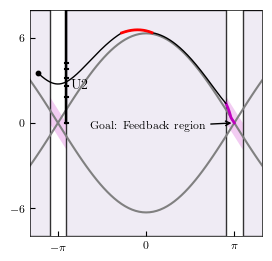

In [4]:
 def plot_u_implemented( ax_p): 
    
    phd.homoclinic_plot(ax_p,-2*np.pi,  2*np.pi, col = homoclinic_col) 
    
    use_list = data_list[7]
    y_data = np.array( use_list[1] )
    u_data = np.array( use_list[2] ) 

    LQR_bool = np.array( [ item=='LQR'   for item in use_list[3]   ] )
#     FF_bool = np.array( [ item=='FF'   for item in use_list[3]   ] )
    FF_bool = np.array([ 'FF' in item for item in use_list[3] ])
    FF_on_bool = FF_bool & (np.abs(u_data)>0.1)
     

    neither_bool = ~LQR_bool & ~FF_bool 

    s1= ax_p.scatter(  y_data[0,0], y_data[0,1],10, color='k',label='IC')
    l2 =  ax_p.plot(  y_data[FF_on_bool,0], y_data[FF_on_bool,1] ,color=ff_col,label='Feedforward' ,linewidth=2,zorder =3) 
    l1 = ax_p.plot(  y_data[LQR_bool,0], y_data[LQR_bool,1],color=lqr_col,label ='LQR',linewidth=2) 
    ax_p.plot(  y_data[FF_bool,0], y_data[FF_bool,1],'k', label=None ,linewidth=1) 
    
    ax_p.plot( [-5,-5], [-5,-5],'k'  ,label = 'Control off' ) 
    ff.plot_discontinuous_lines(  ax_p , y_data[neither_bool] ,   linewidth=1 )  

    u_bool = np.abs(u_data ) > 0.01 

#     phd.homoclinic_plot(ax_p,-3*np.pi, -1*np.pi) 
#     phd.homoclinic_plot(ax_p,1*np.pi, 3*np.pi)  

    w_2 = 0.6
    L = 16
    rectangle1 = plt.Rectangle( (-w_2/2 - np.pi ,L/2), -L, -L, 
                                zorder=-5, facecolor = obscure_col ,alpha = obscure_alpha ,edgecolor=obscure_edge ) 
    ax_p.add_patch(rectangle1)

    rectangle3 = plt.Rectangle( ( +w_2/2 - np.pi ,L/2), 2*(np.pi-0.3), -L, 
                                zorder=-5, facecolor = obscure_col ,alpha = obscure_alpha,edgecolor=obscure_edge  ) 
    ax_p.add_patch(rectangle3)

    rectangle5 = plt.Rectangle( ( +w_2/2 +np.pi ,L/2), 2*(np.pi-0.3), -L, 
                                zorder=-5, facecolor = obscure_col ,alpha = obscure_alpha ,edgecolor=obscure_edge ) 
    ax_p.add_patch(rectangle5)

    ax_p.set_xlim( -np.pi - 1, np.pi+1 )
    ax_p.set_ylim( -8,8)

    ax_p.xaxis.set_major_locator(plt.MultipleLocator(np.pi )) 
    ax_p.xaxis.set_major_formatter(plt.FuncFormatter(phd.multiple_formatter()))  

    ax_p.yaxis.set_major_locator( plt.MultipleLocator(6) )

    dx =  LQR_limit 

    x_points = np.array([-dx, dx, dx, -dx])+np.pi
    y_points = np.array([1.,0,-1.,0])*1.88
    ax_p.fill( x_points, y_points,facecolor=lqr_fill, zorder = -6,alpha=0.2)
    ax_p.fill( x_points-2*np.pi, y_points,facecolor=lqr_fill, zorder = -6,alpha=0.2,)
  
     
    ax_p.annotate('Goal: Feedback region', (np.pi,0), (-2,-0.5),arrowprops=dict(arrowstyle='->') , fontsize = annotate_font,zorder = 5) 

#     ax_p.legend(bbox_to_anchor=(1.16, 1.)) 
#     ax_p.legend(loc='center left', bbox_to_anchor=(1, 0.8) ,scatterpoints=1 ) 
#     ax_p.get_legend().remove()
    
    for j,(st, end) in enumerate(zip(dth_start,dth_end)) : 

        x_loc = np.array([-1,1])*0.06-np.pi+ LQR_limit
        y_loc = np.array([1,1])*st
        ax_p.plot(x_loc,y_loc,'k')
        ax_p.plot( np.array([1,1])*-np.pi+  LQR_limit , [0,8], color= 'k') 
        if j == 2:
            y_text = np.average([st,end]) -0.5
            ax_p.text( -np.pi+ LQR_limit + 0.15  , y_text , 'U'+str(j))

    return( ax_p  ) 

fig,ax = plt.subplots(1,1, figsize= (3,3) ,dpi = 100) 

plot_u_implemented( ax  )  
 

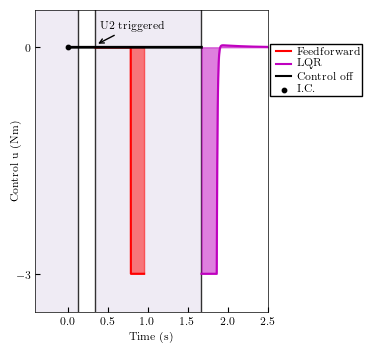

In [5]:

use_list = data_list[7]
y0 = use_list[0] # y0
y_data = np.array( use_list[1] )
u_data = np.array( use_list[2] ) 
u_type = np.array( use_list[3]) # type of u 

LQR_bool = np.array( [ item=='LQR'   for item in use_list[3]   ] )
FF_bool = np.array( [ item=='FF'   for item in use_list[3]   ] )
FF_on_bool = FF_bool & (np.abs(u_data)>0.1)
 

def plot_time_u(ax_p ): 
    
    use_list = data_list[7]
    y0 = use_list[0] # y0
    y_data = np.array( use_list[1] )
    u_data = np.array( use_list[2] ) 
    u_type = np.array( use_list[3]) # type of u 

    LQR_bool = np.array( [ item=='LQR'   for item in use_list[3]   ] )
#     FF_bool = np.array( [ item=='FF'   for item in use_list[3]   ] ) 
    FF_bool = np.array([ 'FF' in item for item in use_list[3] ])
    
    FF_on_bool = FF_bool & (np.abs(u_data)>0.1)



    n_data = len(use_list[1])
    dt = 0.001
    tInt = np.arange(0,len(use_list[1])*dt,dt ) 

    # np.unique(u_type)
#     bool_ff = u_type =='FF'
    bool_ff = FF_bool
    bool_lqr = u_type =='LQR'
    bool_none = (~bool_ff) & (~bool_lqr) 

    #----------------------ax0
    ax_p.plot(tInt[bool_ff], u_data[bool_ff] ,label = 'Feedforward' ,color=ff_col)
    
    ax_p.fill_between(tInt[bool_ff], u_data[bool_ff] ,u_data[bool_ff]*0 ,color=ff_col,alpha = 0.5)
    ax_p.plot(tInt[bool_lqr], u_data[bool_lqr]   ,label = 'LQR',color=lqr_col ) 
    
    ax_p.fill_between(tInt[bool_lqr], u_data[bool_lqr] ,u_data[bool_lqr]*0 ,color=lqr_col,alpha = 0.5)
    ax_p.scatter(0,0,10,'k',label='I.C.')

    ax_p.plot( [-3,-2], [-3,-2],'k'  ,label = 'Control off' ) 
    # ax_p.scatter(tInt[bool_none], u_data[bool_none]  ,1,'k'  ,label = 'coast' ) 

    ff.plot_discontinuous_lines(ax_p, np.vstack([tInt[bool_none], u_data[bool_none]]).transpose() )


    #-obscured 1------------------
    bool_obscured =  (y_data[:,0]  <  (-np.pi-0.3) ) 
    t_obscured = tInt[bool_obscured] 
    t1 = t_obscured[0] -1
    tau = t_obscured[-1] - t1 
    L = 10
    rectangle5 = plt.Rectangle( (  t1 ,L/2), tau, -L, 
                                zorder=-5, facecolor = obscure_col ,alpha = obscure_alpha ,edgecolor=obscure_edge ) 
    ax_p.add_patch(rectangle5)
    
    #-obscured 2------------------
    bool_obscured = (y_data[:,0] > (-np.pi+0.3))  & (y_data[:,0]  <  (np.pi-0.3) ) 
    t_obscured = tInt[bool_obscured] 
    t1 = t_obscured[0]  
    tau = t_obscured[-1] - t1  
    L = 10
    rectangle6 = plt.Rectangle( (  t1 ,L/2), tau, -L, 
                                zorder=-5, facecolor = obscure_col ,alpha = obscure_alpha ,edgecolor=obscure_edge  ) 
    ax_p.add_patch(rectangle6)
    
     

    ax_p.set_xlim([- .4,2.5])
    ax_p.set_ylim([-3.5,.5])


    ax_p.legend(loc='center left', bbox_to_anchor=(1, 0.8) ,scatterpoints=1) 

    ax_p.set_xlabel('Time (s)') 
    ax_p.set_ylabel('Control u (Nm)',   va = 'top')  
    ax_p.set_yticks([-3,0])

    ax_p.annotate('U2 triggered', (0.35,+0.03), (.4,.24),arrowprops=dict(arrowstyle='->') , fontsize = annotate_font,zorder = 5) 

    return( ax_p ) 


fig, ax0= plt.subplots(1,1,figsize=(3,4), dpi = 100 ) 
plot_time_u(ax0) 

    
    

Saving to: D:\Mijn_documenten\Dropbox\A_PhD\C_Papers\ch_neuralControl\timed_feedforward_control\figs\fig4_feedforward_feedback.png and .pdf


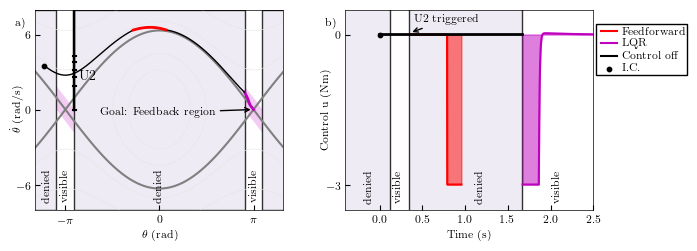

In [6]:

fig = plt.figure( figsize= fig_dim,dpi = 100)
 
ax0= plt.axes([ 0 , 0 , .4  ,  1] )  
ax1= plt.axes([ .5,0 , .4, 1])  # standard axes  
     
 
ff.plot_add_contours(ax0)      
plot_u_implemented( ax0 ) 
ax0.set_xlabel(r'$\theta$ (rad)')
ax0.set_ylabel(r'$\dot{\theta}$ (rad/s)' ,   va = 'top')

yl = -5.5
ax0.text(-np.pi -0.8 ,yl, 'denied',rotation = 90  , fontsize = 8 )
ax0.text( -np.pi-0.2,yl,'visible',rotation = 90  , fontsize = 8) 
ax0.text( -.2 ,yl ,'denied',rotation = 90   , fontsize = 8)
ax0.text( np.pi-0.2,yl,'visible' ,rotation = 90  , fontsize = 8) 

 

yl =- 2.9
ax1.text(-0.2  ,yl ,'denied',rotation = 90  , fontsize = 8 )
ax1.text(0.15,yl,'visible',rotation = 90  , fontsize = 8) 
ax1.text(1.1 ,yl ,'denied',rotation = 90  , fontsize = 8 )
ax1.text( 2,yl,'visible' ,rotation = 90 , fontsize = 8 ) 

    
plot_time_u(ax1)  

label_dict = dict( fontsize = 8 , fontweight='bold' )   
# ff.label_axes(fig,labels =['a)','b)','c)','d)'], loc=(-0.1,.95 ) , **label_dict  )
ff.label_axes2(fig,labels =['a)','b)','c)','d)'], loc=(-0.2,0.92 ) , **label_dict   )
 

ff.save_fig(fig, figs_path, fig_name)  